<a href="https://colab.research.google.com/github/Shopping-Yuan/ML_Project/blob/Shopping_vscode_branch/GBDT/GBDT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'house-prices-advanced-regression-techniques:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F5407%2F868283%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240604%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240604T054634Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8599622bdd97015cbc78839527a7c212506420c60a79503453d966f40c9ed797b2e8efd9bfeab96719bc88a3a54c7877901c12574bb4b6c37461eac432ea274b0456d7fc6757744198b59049fedbf6058f21974d94de9ff3725d02121eb1c046ce2b5ed413150b38639caebdae19fa00d369002658bd7d237918c19b808aa1e7f911a7e2103e8882c153be79c7bedc128ab27ce42f5e534d99c71f76f825119949d5a12414cd6d64584d985da45757582ebc57da1bc3e34b84928364d185056490840d4fb953cbba0e0918aa3b0ecc30bddbbb05d3c5938da309a2bfd25d2b26e543987459a5fb6418bb5db4b889ff832e26b14d08bf1733121ec6c8c764f381'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 203809 bytes downloaded
Downloaded and uncompressed: house-prices-advanced-regression-techniques
Data source import complete.


In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv


In [57]:
from sklearn.model_selection import train_test_split
train_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [58]:
train_df.dtypes
train_df.columns.values

array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'Pav

Drop id and columns with too many missing values.

In [59]:
train_df = train_df.replace([np.inf, -np.inf, ""], np.nan)
null = train_df.isnull().sum()
notnull = train_df.notnull().sum()
miss_portion = null[null > 0]/(null[null > 0]+notnull[null > 0])
drop_features = miss_portion[miss_portion > 0.5].index.values
drop_features = np.append(drop_features,["Id"])
drop_features

array(['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature', 'Id'],
      dtype=object)

In [60]:
train_data = train_df.drop(axis=0,columns=drop_features,errors='raise')
test_data = test_df.drop(axis=0,columns=drop_features,errors='raise')

In [61]:
train_data.columns.values
train_data.shape

(1460, 75)

In [62]:
null = train_data.isnull().sum()
notnull = train_data.notnull().sum()
miss_portion = null[null > 0]/(null[null > 0]+notnull[null > 0])
miss_portion

LotFrontage     0.177397
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
dtype: float64

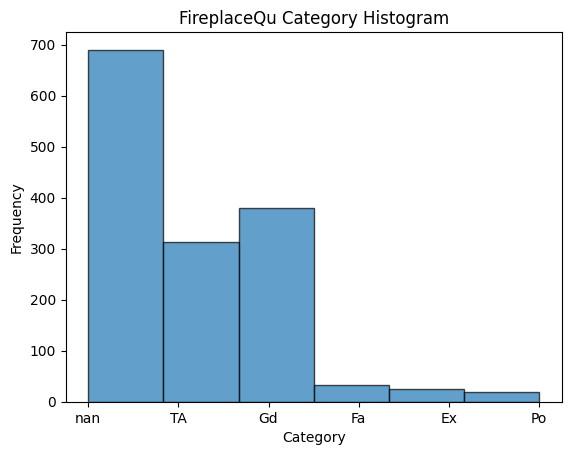

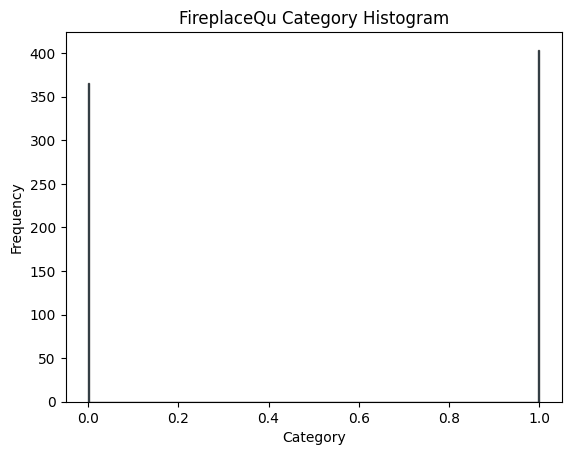

In [63]:
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(train_data["FireplaceQu"].to_list(), bins=len(set(train_data["FireplaceQu"])), edgecolor='black', alpha=0.7)
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('FireplaceQu Category Histogram')
plt.show()

train_data["FireplaceQu"] = train_data["FireplaceQu"].replace(["Ex","Gd","TA","Fa","Po"], [1,1,0,0,0])
plt.hist(train_data["FireplaceQu"].to_list(), bins=len(set(train_data["FireplaceQu"])), edgecolor='black', alpha=0.7)
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('FireplaceQu Category Histogram')
plt.show()

In [64]:
from sklearn.preprocessing import LabelEncoder
def labelencoder(dataset,name):
  label_encoder = LabelEncoder()
  dataset[name] = label_encoder.fit_transform(dataset[name])

In [66]:

fireplaceQu_df = train_data[train_data["FireplaceQu"].isin([1,0]) ][["FireplaceQu","SalePrice"]]
labelencoder(fireplaceQu_df,"FireplaceQu")
fireplaceQu_df.corr()

,FireplaceQu,SalePrice
FireplaceQu,1.000000,0.200584
SalePrice,0.200584,1.000000


In [71]:
train_data["FireplaceQu"] = train_data["FireplaceQu"].replace(np.nan, 0.5)
train_data["FireplaceQu"].head()

0    0.5
1    0.0
2    0.0
3    1.0
4    0.0
Name: FireplaceQu, dtype: float64

In [ ]:
# from sklearn.preprocessing import LabelEncoder
def labelencoder(dataset):
    names = list(train.dtypes[train.dtypes == object].index)
    dataset_encoder = pd.DataFrame()
    for name in dataset.columns:
        if name in names:
            label_encoder = LabelEncoder()
            dataset_encoder[name] = label_encoder.fit_transform(dataset[name])
            # dataset_encoder = pd.concat([dataset_encoder,pd.get_dummies(dataset[name])],axis = 1)
        else :
            dataset_encoder[name] = dataset[name]
    return dataset_encoder


train_encoder = labelencoder(train.drop(["Id"],axis = 1))
test_encoder = labelencoder(test.drop(["Id"],axis = 1))

In [ ]:
train_encoder.head(20)
len(train_encoder.columns)
train_encoder.isnull().any()
# train_encoder.shape

MSSubClass    False
C (all)       False
FV            False
RH            False
RL            False
              ...  
Alloca        False
Family        False
Normal        False
Partial       False
SalePrice     False
Length: 288, dtype: bool

In [ ]:
import numpy as np
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=10)
impute_training_set = pd.DataFrame(imputer.fit_transform(train_encoder),columns = list(train_encoder.columns))
impute_testing_set = pd.DataFrame(imputer.fit_transform(test_encoder),columns = list(test_encoder.columns))
impute_training_set.head(20)

,MSSubClass,C (all),FV,RH,RL,RM,LotFrontage,LotArea,Grvl,Pave,...,New,Oth,WD,Abnorml,AdjLand,Alloca,Family,Normal,Partial,SalePrice
0,60.0,0.0,0.0,0.0,1.0,0.0,65.0,8450.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,208500.0
1,20.0,0.0,0.0,0.0,1.0,0.0,80.0,9600.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,181500.0
2,60.0,0.0,0.0,0.0,1.0,0.0,68.0,11250.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,223500.0
3,70.0,0.0,0.0,0.0,1.0,0.0,60.0,9550.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,140000.0
4,60.0,0.0,0.0,0.0,1.0,0.0,84.0,14260.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,250000.0
5,50.0,0.0,0.0,0.0,1.0,0.0,85.0,14115.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,143000.0
6,20.0,0.0,0.0,0.0,1.0,0.0,75.0,10084.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,307000.0
7,60.0,0.0,0.0,0.0,1.0,0.0,78.0,10382.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,200000.0
8,50.0,0.0,0.0,0.0,0.0,1.0,51.0,6120.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,129900.0
9,190.0,0.0,0.0,0.0,1.0,0.0,50.0,7420.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,118000.0


In [ ]:
train_set,val_set = train_test_split(impute_training_set, test_size=0.2, random_state=1)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(train_set.drop(["SalePrice"],axis = 1), train_set["SalePrice"])
# clf.score(X_test, y_test)

In [ ]:
clf.score(val_set.drop(["SalePrice"],axis = 1), val_set["SalePrice"])

0.003424657534246575

In [ ]:
clf.predict(impute_testing_set)


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- 2.5Fin
- ClyTile
- Floor
- Membran
- Metal
- ...
